In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from collections import Counter
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost
import inspect
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
import warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#load dataset
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
sample = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
df.head(3)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0


In [3]:
#place the Ids in a variable to use it later for submission
test_ids = test['Id']

In [4]:
##For the categorical columns ('Id' and 'EJ'), we use the 'fit_transform' method of the 'LabelEncoder' to transform the data.
encoder = LabelEncoder()
df['Id'] = encoder.fit_transform(df['Id']).astype(float)
test['Id'] = encoder.fit_transform(test['Id']).astype(float)

df['EJ'] = encoder.fit_transform(df['EJ']).astype(float)
test['EJ'] = encoder.fit_transform(test['EJ']).astype(float)

KNNImputer replaces missing values with the mean of the 'k' nearest neighbors in the feature space.

In [5]:
# First, we create an instance of the 'KNNImputer' class.'n_neighbors=10', meaning the algorithm will use the 10 nearest neighbors.
imputer = KNNImputer(n_neighbors=10)

#Extract the column names from the DataFrames for later use
df_col = df.columns
test_col = test.columns

# Use the 'fit_transform' method of the 'KNNImputer' to impute missing values in each DataFrame.
# The 'fit_transform' method returns a new array with the imputed values.
df_imputed = imputer.fit_transform(df)
test_imputed = imputer.fit_transform(test)

#We create new DataFrames using the imputed values and assign the original column names to them
df = pd.DataFrame(df_imputed, columns=df_col)
test = pd.DataFrame(test_imputed, columns=test_col)

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

#Performs feature selection using the SelectKBest method

def feature_selection(df, test, threshold=0.1, t_score=5):
    # Initiate the SelectKBest function with f_classif score function and k 
    fs = SelectKBest(score_func=f_classif, k=len(df.columns))

    # Apply feature selection on the training data and target variable
    X_selected = fs.fit_transform(df, test.values)

    # Initialize lists to store selected and dropped features along with their p-values
    new_features = []  # The list of features with p-values less than the threshold
    drop_features = []  # The list of features with p-values higher than the threshold
    p_values = []  # The list of p-values for each feature

    # Iterate through each column in the DataFrame
    for i in range(len(df.columns)):
        # Check if the p-value is less than or equal to the threshold and t-score is above t_score
        if fs.pvalues_[i] <= threshold and fs.scores_[i] >= t_score:
             # Add the feature to the list of new_features
            new_features.append(df.columns[i])
        else:
            # Otherwise, add the feature to the list of drop_features
            drop_features.append(df.columns[i])
       # Add the p-value of the current feature to the list of p_values
        p_values.append(fs.pvalues_[i])

   # Create a DataFrame with the selected features and their values
    X_selected_final = pd.DataFrame(X_selected)
    X_selected_final.columns = df.columns
    X_selected_final = X_selected_final[new_features]

    # Return the selected features DataFrame, lists of selected and dropped features, and the list of p-values
    return X_selected_final, new_features, drop_features, p_values

In [7]:
#set the random state to the same value
state= 0

In [8]:
#Split the data for training

X = df.drop(columns = {"Class"})
y = df.pop('Class')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

In [9]:
#Split the data after feature selection using the SelectKBest method
X_filtered, new_features, drop_features, p_values = feature_selection(X, y, threshold=0.1, t_score=5)

In [10]:
print('remain feature: ', new_features)

remain feature:  ['AB', 'AF', 'AM', 'AX', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BZ', 'CD ', 'CF', 'CR', 'DA', 'DE', 'DH', 'DI', 'DL', 'DU', 'EE', 'EH', 'EJ', 'FD ', 'FE', 'FI', 'FL', 'FR', 'GF', 'GL']


In [11]:
print('drop feature: ', drop_features)

drop feature:  ['Id', 'AH', 'AR', 'AY', 'AZ', 'BR', 'CB', 'CC', 'CH', 'CL', 'CS', 'CU', 'CW ', 'DF', 'DN', 'DV', 'DY', 'EB', 'EG', 'EL', 'EP', 'EU', 'FC', 'FS', 'GB', 'GE', 'GH', 'GI']


In [12]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

In [13]:
#Split the data after feature selection on the training data and target variable
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=state)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [15]:
#The 2 models selected to test in this notebook
# Random Forest Classifier (model_rf)
model_rf = RandomForestClassifier()
# LightGBM Classifier (model_lgb) with objective set to 'binary' for binary classification tasks
model_lgb = lgb.LGBMClassifier(objective='binary')

In [16]:
#Parameter grids for the two models to be used during hyperparameter tuning
param_rf = {
    'n_estimators': [10, 50, 100, 150],       # Number of trees in the forest
    'criterion': ['entropy'],                # The function to measure the quality of a split
    'min_samples_split': [2, 5],             # The minimum number of samples required to split an internal node
    'max_depth': [None, 2],                  # The maximum depth of the tree. None means nodes are expanded until all leaves are pure
    'min_samples_leaf': [1, 3, 10],          # The minimum number of samples required to be at a leaf node
    'max_features': ['sqrt']                 # The number of features to consider when looking for the best split
}

# Parameter grid for LightGBM Classifier (model_lgb)
param_lgb = {
    'num_leaves': [10, 20, 30],              # Maximum number of leaves in one tree
    'max_depth': [5, 10],                    # Maximum tree depth
    'learning_rate': [0.01, 0.1],            # Boosting learning rate
    'n_estimators': [100, 200],              # Number of boosting iterations
    'subsample': [0.6, 0.8, 1.0]             # Subsample ratio of the training instance
}

In [17]:
#Use the GridSearchCV function from scikit-learn to perform hyperparameter tuning for the Random Forest Classifier (model_rf).
GSRF1 = GridSearchCV(model_rf, param_rf, cv=5, scoring='roc_auc')
GSRF1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [None, 2],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='roc_auc')

In [18]:
print('best_param:', GSRF1.best_params_)
print('best_score:', GSRF1.best_score_)

best_param: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
best_score: 0.9563580246913579


In [19]:
#Use the GridSearchCV function from scikit-learn to perform hyperparameter tuning for the LightGBM Classifier (model_lgb).
GS_LGB1 = GridSearchCV(model_lgb, param_lgb, cv=5, scoring='roc_auc')
GS_LGB1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(objective='binary'),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 10],
                         'n_estimators': [100, 200], 'num_leaves': [10, 20, 30],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc')

In [20]:
print('best_param:', GS_LGB1.best_params_)
print('best_score:', GS_LGB1.best_score_)

best_param: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 10, 'subsample': 0.6}
best_score: 0.9528463648834018


In [21]:
#Best-tuned Random Forest Classifier (GSRF1) to make predictions on the test data (X_test) 
#Print a classification report to evaluate the model's performance.
pred_rf1 = GSRF1.predict(X_test)
print(classification_report(y_test, pred_rf1))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       106
         1.0       0.65      0.61      0.63        18

    accuracy                           0.90       124
   macro avg       0.79      0.78      0.78       124
weighted avg       0.89      0.90      0.89       124



In [22]:
#Best-tuned LightGBM Classifier (LGB1) to make predictions on the test data (X_test) 
#Print a classification report to evaluate the model's performance.
pred_lgb1 = GS_LGB1.predict(X_test)
print(classification_report(y_test, pred_lgb1))

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       106
         1.0       0.62      0.72      0.67        18

    accuracy                           0.90       124
   macro avg       0.79      0.82      0.80       124
weighted avg       0.90      0.90      0.90       124



**SMOTE** (Synthetic Minority Over-sampling Technique) is a useful technique when training classification models with imbalanced datasets. By augmenting the minority class data, SMOTE helps to improve the performance of the classification models. When training with imbalanced data, there are often too few samples of the minority class, causing the model to not learn the characteristics of the minority class properly. SMOTE creates new synthetic samples by increasing the number of minority class samples through a process of augmentation, and by augmenting the training dataset in this way, the performance of the model can be improved. In summary, SMOTE can improve the accuracy of classification models in problems with imbalanced class distributions.

In [23]:
smote = SMOTE()

In [24]:
#Use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class in the training data.
X_smt, y_smt = smote.fit_resample(X_train, y_train)

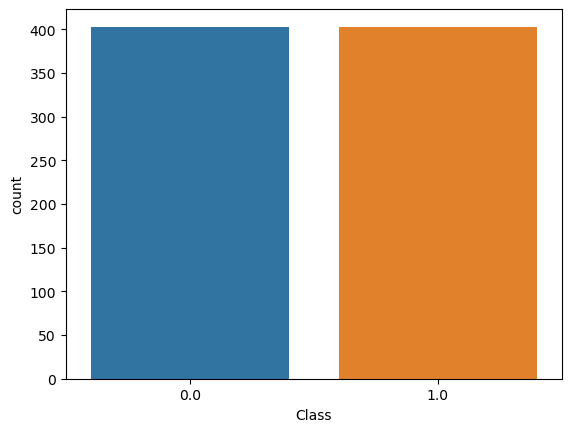

In [25]:
#Count plot to visualize the class distribution of the target variable after applying SMOTE
ax = sns.countplot(x=y_smt)

In [26]:
#Use the GridSearchCV function from scikit-learn to perform hyperparameter tuning for the Random Forest Classifier (model_rf) using the oversampled data (X_smt and y_smt) after applying SMOTE. 
GSRF2 = GridSearchCV(model_rf, param_rf, cv=5, scoring='roc_auc')
GSRF2.fit(X_smt, y_smt)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [None, 2],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='roc_auc')

In [27]:
print('best_param:', GSRF2.best_params_)
print('best_score:', GSRF2.best_score_)

best_param: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
best_score: 0.9913877457704618


In [28]:
#Use the GridSearchCV function from scikit-learn to perform hyperparameter tuning for the LightGBM Classifier (model_lgb) using the oversampled data (X_smt and y_smt) after applying SMOTE
GS_LGB2 = GridSearchCV(model_lgb, param_lgb, cv=5, scoring='roc_auc')
GS_LGB2.fit(X_smt, y_smt)

GridSearchCV(cv=5, estimator=LGBMClassifier(objective='binary'),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 10],
                         'n_estimators': [100, 200], 'num_leaves': [10, 20, 30],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc')

In [29]:
print('best_param:', GS_LGB2.best_params_)
print('best_score:', GS_LGB2.best_score_)

best_param: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 20, 'subsample': 0.6}
best_score: 0.9970000762078952


In [30]:
#Best-tuned Random Forest Classifier (GSRF2) with hyperparameters obtained from GridSearchCV to make predictions on the test data (X_test).
pred_rf2 = GSRF2.predict(X_test)
print(classification_report(y_test, pred_rf2))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       106
         1.0       0.62      0.89      0.73        18

    accuracy                           0.90       124
   macro avg       0.80      0.90      0.83       124
weighted avg       0.93      0.90      0.91       124



In [31]:
#Best-tuned LightGBM Classifier (LGB2) with hyperparameters obtained from GridSearchCV to make predictions on the test data (X_test).
pred_lgb2 = GS_LGB2.predict(X_test)
print(classification_report(y_test, pred_lgb2))

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       106
         1.0       0.64      0.89      0.74        18

    accuracy                           0.91       124
   macro avg       0.81      0.90      0.85       124
weighted avg       0.93      0.91      0.92       124



In [32]:
#Remove the same columns as in the train dataframe
test_scaled = test[['AB', 'AF', 'AM', 'AX', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BZ', 'CD ',
       'CF', 'CR', 'DA', 'DE', 'DH', 'DI', 'DL', 'DU', 'EE', 'EH', 'FD ', 'FE',
       'FI', 'FL', 'FR', 'GF', 'GL', 'EJ']]

In [33]:
#Best-tuned LightGBM Classifier (GS_LGB1) with hyperparameters obtained from GridSearchCV to predict probabilities for the test dataframe.
lgb_pred = GS_LGB1.predict_proba(test_scaled)
lgb_pred

array([[0.9736326, 0.0263674],
       [0.9736326, 0.0263674],
       [0.9736326, 0.0263674],
       [0.9736326, 0.0263674],
       [0.9736326, 0.0263674]])

In [34]:
#Best-tuned LightGBM Classifier (GS_LGB2) with hyperparameters obtained from GridSearchCV to predict probabilities for the test dataframe.
lgb_pred = GS_LGB2.predict_proba(test_scaled)
lgb_pred

array([[0.99580545, 0.00419455],
       [0.99580545, 0.00419455],
       [0.99580545, 0.00419455],
       [0.99580545, 0.00419455],
       [0.99580545, 0.00419455]])

Take for submission the model with best results. 

Best-tuned LightGBM Classifier (GS_LGB1) with hyperparameters obtained from GridSearchCV to predict probabilities for a new dataset (test_scaled). Create a submission DataFrame in a specific format for a binary classification problem. The submission DataFrame contains the predicted probabilities for each class (class_0 and class_1) and the corresponding IDs for the test data.

In [37]:
pred = GS_LGB1.predict_proba(test_scaled)[:, 1]

submission = pd.DataFrame({'Id': test_ids, 'class_0': 1 - pred, 'class_1': pred})
submission

,Id,class_0,class_1
0,00eed32682bb,0.973633,0.026367
1,010ebe33f668,0.973633,0.026367
2,02fa521e1838,0.973633,0.026367
3,040e15f562a2,0.973633,0.026367
4,046e85c7cc7f,0.973633,0.026367


In [38]:
submission.to_csv('submission.csv', index=False)